In [1]:
import os
import sys
import time

import numpy as np
import pandas as pd
import math
from tqdm import tqdm

from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import collections as coll
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KDTree

sys.path.append("../..")
import merge as merge
import extension as ext
import zroutlier as zro
import free_hits as free
import track_score as score2
import straight_tracks as strt
import eda_utils as eda
import r0outlier as r0o

%matplotlib inline

In [2]:
TRAIN_PATH = '../../../input/train_1'
event_id = 1000

In [3]:

event_prefix = 'event00000' + str(event_id)
hits, cells, particles, truth = load_event(os.path.join(TRAIN_PATH, event_prefix))

mem_bytes = (hits.memory_usage(index=True).sum() 
             + cells.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())
print('{} memory usage {:.2f} MB'.format(event_prefix, mem_bytes / 2**20))

event000001000 memory usage 18.46 MB


In [4]:
labels_helix = pd.read_csv('../../1000_r0_exp4/event_1000_labels_train_helix6_phase1_dbscan1.csv').label.values

In [5]:
def create_one_event_submission(event_id, hits, labels):
    sub_data = np.column_stack(([event_id]*len(hits), hits.hit_id.values, labels))
    submission = pd.DataFrame(data=sub_data, columns=["event_id", "hit_id", "track_id"]).astype(int)
    return submission

def score_one_submission(event_id, hits, labels, truth):
    submission = create_one_event_submission(event_id, hits, labels)
    score = score_event(truth, submission)
    print("Score for event %d: %.8f" % (event_id, score))

In [6]:
score_one_submission(event_id, hits, labels_helix, truth)


Score for event 1000: 0.54537665


In [7]:
hits['z_abs'] = hits.z.abs()
hits['r'] = np.sqrt(hits.x**2+hits.y**2)
hits['zr'] = hits['z'] / hits['r']
hits['azr'] = np.arctan2(hits['z'], hits['r'])

In [8]:
def track_distance_from_truth(track, labels, hits, truth):
    hit_ix = np.where(labels == track)[0]
    df = hits.loc[hit_ix]
    df = df.sort_values('z')
    #dfx1 = df[['x','y', 'z', 'zr', 'volume_id', 'layer_id']]
    truth_ix = eda.get_truth_for_track(track, labels, truth)

    arr_s1 = np.copy(hit_ix)
    arr_s1.sort()
    arr_s2 = np.copy(truth_ix)
    arr_s2.sort()

    correct = 0
    incorrect = 0
    if not np.array_equal(arr_s1, arr_s2):
        for hit in arr_s1:
            if hit in arr_s2:
                correct = correct + 1
            else:
                incorrect = incorrect + 1
        # If distance is still 0, it means the all hits are in the truth, but
        # the truth contains extra hits as well. Just set distance to 1 for now.
        if incorrect == 0:
            incorrect = 1
    return (correct, incorrect)

In [9]:
def is_horrible_track(track, labels, hits):
    hit_ix = np.where(labels==track)[0]
    df = hits.iloc[hit_ix]
    df = df.sort_values('z')
    vols = df.volume_id.values
    lays = df.layer_id.values
    zs = df.z.values
    dupz_count = 0
    seen_vols = [0]
    seen_lays = [0]
    horrible = 0
    last_lay_count = 0
    for ix, vol in enumerate(vols):
        if vol != seen_vols[-1]:
            seen_lays = [lays[ix]]
            # Check if vol in seen_vols (i.e. go back and forth between volumes)
            # 8/14/0 (so-so, not too great though, too many false positives!)
            seen_vols.append(vol)
            last_lay_count = 1
        elif lays[ix] != seen_lays[-1]:
            if vol != 7 and vol != 9 and (lays[ix] != (seen_lays[-1] + 2)) and (lays[ix] != (seen_lays[-1] - 2)):
                horrible = 3
                break
            seen_lays.append(lays[ix])
            last_lay_count = 1
        else:
            last_lay_count = last_lay_count + 1
            # count==7: 3/0/0, count==6: 15/2/0, count==5: 28/8/0, count==4: 83/87/2
            if last_lay_count == 4:
                horrible = 1
                break
        if ix > 0 and zs[ix] == zs[ix-1] and vol == vols[ix-1] and lays[ix] == lays[ix-1]:
            dupz_count = dupz_count + 1
            # count==1: 30/17/0, count==2: 21/4/0, count==3: 12/2/0, count==4: 11/0/0
            if dupz_count == 1:
                horrible = 2
                break

    return horrible
    
def find_horrible_tracks(labels, hits):
    tracks = np.unique(helix6)
    horrible_tracks = []
    for track in tracks:
        if track == 0: continue
        if is_horrible_track(track, labels, hits):
            horrible_tracks.append(track)
    return horrible_tracks

def find_badr0_tracks(labels, hits):
    bad_r0s = []
    tracks = np.unique(labels)
    for track in tracks:
        if track == 0: continue
        tix = np.where(labels==track)[0]
        if len(tix) < 4:
            continue
        t = hits.iloc[tix].as_matrix(columns=['x','y','z'])
        t = t[np.argsort(np.fabs(t[:,2]))]
        x0, y0, r0  = helix_estimate_param_from_track(t)
        #print('ii: ' + str(ii) + ', r0: '+ str(r0))
        if int(r0) >= 325:
            bad_r0s.append(track)
    return bad_r0s

In [10]:
helix = np.copy(labels_helix)
#helix = merge.remove_outliers(helix, hits, smallest_track_size=6, aggressive=False, print_counts=False)
(helix, small_count) = merge.remove_small_tracks(helix, smallest_track_size=6)
#helix = r0o.remove_badr0_tracks(helix, hits)
helix = merge.renumber_labels(helix)
tracks = np.unique(helix)
short_tracks = []
perfect_tracks = []
imperfect_tracks = []
horrible_tracks = []
for track in tracks:
    if track == 0: continue
    tix = np.where(helix == track)[0]
    if len(tix) < 6:
        short_tracks.append(track)
    else:
        (correct,incorrect) = track_distance_from_truth(track, helix, hits, truth)
        if incorrect == 0:
            perfect_tracks.append(track)
        elif incorrect <= 4 and correct >= incorrect:
            imperfect_tracks.append(track)
        else:
            horrible_tracks.append(track)

print('Total tracks:     ' + str(len(tracks)))
print('Short tracks:     ' + str(len(short_tracks)))
print('Perfect tracks:   ' + str(len(perfect_tracks)))
print('Imperfect tracks: ' + str(len(imperfect_tracks)))
print('Horrible tracks:  ' + str(len(horrible_tracks)))
print(horrible_tracks)
# tracks: 6333, perfect 1252, imperfect 4725, horrible 355

Total tracks:     6333
Short tracks:     0
Perfect tracks:   1252
Imperfect tracks: 4725
Horrible tracks:  355
[19, 36, 38, 39, 41, 42, 78, 210, 262, 321, 417, 428, 501, 507, 513, 553, 578, 587, 616, 643, 646, 688, 694, 730, 738, 752, 754, 856, 857, 885, 1011, 1030, 1061, 1080, 1093, 1125, 1134, 1172, 1181, 1212, 1233, 1260, 1304, 1383, 1395, 1413, 1423, 1425, 1562, 1566, 1627, 1644, 1650, 1657, 1714, 1730, 1737, 1760, 1764, 1767, 1790, 1828, 1831, 1832, 1928, 1933, 1958, 1974, 1990, 1992, 2031, 2073, 2085, 2133, 2140, 2161, 2239, 2265, 2269, 2321, 2330, 2334, 2400, 2425, 2437, 2472, 2493, 2502, 2548, 2549, 2550, 2554, 2590, 2593, 2594, 2597, 2609, 2648, 2653, 2689, 2692, 2713, 2726, 2740, 2785, 2824, 2833, 2835, 2836, 2870, 2880, 2907, 2911, 2926, 2942, 2945, 2976, 2995, 3001, 3010, 3014, 3022, 3033, 3058, 3060, 3068, 3094, 3095, 3106, 3132, 3142, 3146, 3151, 3159, 3165, 3167, 3169, 3172, 3174, 3175, 3180, 3185, 3187, 3189, 3209, 3213, 3220, 3221, 3236, 3247, 3248, 3249, 3273, 3289, 3

In [11]:
#print('Perfect tracks:   ' + str(perfect_tracks))
print('Imperfect tracks: ' + str(imperfect_tracks))
#print('Horrible tracks:  ' + str(horrible_tracks))

Imperfect tracks: [1, 4, 10, 12, 13, 14, 15, 17, 18, 20, 21, 22, 23, 25, 26, 32, 34, 35, 37, 40, 43, 44, 45, 46, 47, 48, 49, 50, 52, 54, 55, 56, 57, 59, 60, 61, 64, 65, 69, 70, 71, 72, 73, 74, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 90, 92, 93, 94, 95, 96, 97, 100, 101, 103, 104, 106, 107, 108, 109, 111, 113, 115, 116, 117, 118, 121, 122, 123, 124, 126, 127, 128, 129, 130, 131, 134, 136, 137, 138, 139, 144, 145, 148, 149, 153, 154, 155, 160, 161, 162, 163, 164, 165, 168, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 184, 185, 186, 187, 188, 189, 190, 191, 192, 194, 196, 197, 198, 199, 200, 201, 202, 206, 211, 212, 213, 214, 215, 216, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 233, 234, 235, 237, 238, 239, 240, 241, 242, 243, 249, 250, 251, 252, 253, 254, 255, 256, 260, 261, 263, 264, 265, 266, 271, 273, 274, 275, 277, 281, 284, 285, 286, 287, 288, 289, 291, 292, 294, 295, 296, 297, 298, 299, 301, 302, 305, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319,

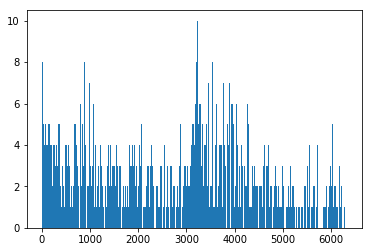

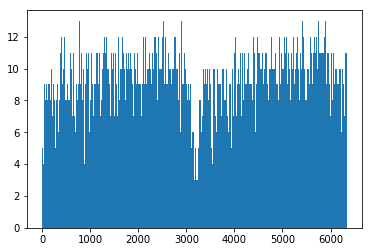

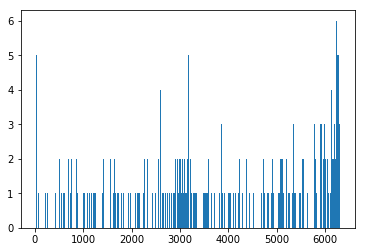

In [12]:
count, bins, ignored = plt.hist(perfect_tracks, 500)#, normed=True)
plt.show()
count, bins, ignored = plt.hist(imperfect_tracks, 500)#, normed=True)
plt.show()
count, bins, ignored = plt.hist(horrible_tracks, 500)#, normed=True)
plt.show()

In [13]:
from scipy.optimize import least_squares

def helix_estimate_param_from_track(track_ix, hits):
    
    def residuals_xy(param, x, y):
        x0, y0 = param
        r = np.sqrt((x-x0)**2 + (y-y0)**2)
        d = r - r.mean()
        return d
    
    def residuals_z(param, r, z):
        m2,m1,m0 = param
        zz = m2*r**2 + m1*r + m0
        d = z - zz
        return d

    df = hits.iloc[track_ix]
    #t = df.as_matrix(columns=['x','y','z'])
    t = df[['x', 'y', 'z']].values
    #print(t)
    t = t[np.argsort(np.fabs(t[:,2]))]
    #print(t)

    x = t[:,0]
    y = t[:,1]
    #z = xyz[:,2]
    param0 = (x.mean(), y.mean())
    res_lsq0 = least_squares(residuals_xy, param0, loss='soft_l1', f_scale=1.0, args=(x,y))
    x0,y0 = res_lsq0.x
    r0 = np.sqrt((x-x0)**2 + (y-y0)**2).mean()

    x = t[0:int(len(t)/2),0]
    y = t[0:int(len(t)/2),1]
    #z = xyz[:,2]
    param1 = (x.mean(), y.mean())
    res_lsq1 = least_squares(residuals_xy, param1, loss='soft_l1', f_scale=1.0, args=(x,y))
    x1,y1 = res_lsq1.x
    r1 = np.sqrt((x-x1)**2 + (y-y1)**2).mean()

    x = t[int(len(t)/2):,0]
    y = t[int(len(t)/2):,1]
    #z = xyz[:,2]
    
    param2 = (x.mean(), y.mean())
    res_lsq2 = least_squares(residuals_xy, param2, loss='soft_l1', f_scale=1.0, args=(x,y))
    x2,y2 = res_lsq2.x
    r2 = np.sqrt((x-x2)**2 + (y-y2)**2).mean()
    #r = np.sqrt(x**2 + y**2)
    
    #if 1:
    #    param0 = (0,0,0)
    #    res_lsq = least_squares(residuals_z, param0, args=(r, z))
    #    m2, m1, m0 = res_lsq.x
        
    #if 0:
    #    # polynomial fit of the degree 2, x**2 - quadradic 
    #    m2,m1,m0 = np.polyfit(r,z,2)
        
    #param = (x0,y0,r0,m1,m2,m0)
    param = (r0,r1,r2)
    return param

# 3 points - x0, x1, x2, convert to 2 vectors
# 1: x1-x0, y1-y0      2: x2-x1, y2-y1
def find_circle_curvature(d01x, d01y, d12x, d12y):
    x01 = d01x
    y01 = d01y
    x12 = d12x
    y12 = d12y
    x02 = x01 + x12;
    y02 = y01 + y12;
    # length of the triangle sides
    a = (x12**2 + y12**2)**0.5 #np.sqrt(x12**2, y12**2)
    b = (x02**2 + y02**2)**0.5 #np.sqrt(x02**2, y02**2)
    c = (x01**2 + y01**2)**0.5 #np.sqrt(x01**2, y01**2)
    # 2 * (signed) area of the triangle
    k = (x02 * y01 - x01 * y02);
    # radius = product of side lengths / 4 times triangle area
    return (2 * k) / (a * b * c);

def find_track_curvature(track, labels, hits):
    trk_ix = np.where(labels == track)[0]
    if len(trk_ix) < 5:
        #print('Track too short: ' + str(track))
        return (0, 0)
    df = hits.loc[trk_ix]
    df = df.sort_values('z_abs')
    x = df.x.values
    y = df.y.values
    mid = int(len(x)/2)
    d01xa = x[0]
    d01ya = y[0]
    d12xa = x[mid] - d01xa
    d12ya = y[mid] - d01ya
    
    d01xb = x[mid]
    d01yb = y[mid]
    d12xb = x[-1] - d01xb
    d12yb = y[-1] - d01yb

    d01xc = x[1]
    d01yc = y[1]
    d12xc = x[-1] - d01xc
    d12yc = y[-1] - d01yc

    curv02a = find_circle_curvature(d01xa, d01ya, d12xa, d12ya)
    curv02b = find_circle_curvature(d01xb, d01yb, d12xb, d12yb)
    curv02c = find_circle_curvature(d01xc, d01yc, d12xc, d12yc)
    #print(curv02a)
    #print(curv02b)
    #print(curv02c)
    return (curv02a, curv02b, curv02c)

In [18]:
# tracks: 6333, perfect 1252, imperfect 4725, horrible 355
labels = np.copy(helix)
reject = []
reject_c1 = []
reject_c2 = []
reject_c3 = []
accept = []
accept_ratio = []
accept_c1 = []
accept_c2 = []
great = []
great_c1 = []
great_c2 = []
great_c3 = []
great_reject = []
for ii in range(len(imperfect_tracks)):
    #if ii < 10: continue
    track_id = imperfect_tracks[ii]
    #track_id = imperfect_tracks[ii]
    (curv1, curv2, curv3) = find_track_curvature(track_id, labels, hits)
    #eda.compare_track_to_truth(track_id, labels, hits, truth)
    if np.sign(curv1) != np.sign(curv2) or np.sign(curv1) != np.sign(curv3):
        reject.append(track_id)
        #reject_c1.append(curv1)
    else:
        c1 = min(abs(curv1), abs(curv2))
        c2 = max(abs(curv1), abs(curv2))
        c3 = abs(curv3)
        ratio = 1.0 - c1/c2
        if ratio > 0.50:# and c1 > 0.003:
            reject.append(track_id)
            reject_c1.append(c1)
            reject_c2.append(c2)
            reject_c3.append(abs(curv3))
        else:
            if ratio < 0.1:
                hit_ix = np.where(labels == track_id)[0]
                if is_horrible_track(track_id, labels, hits):
                    great_reject.append(track_id)
                elif len(hit_ix) > 20:
                    great_reject.append(track_id)
                else:
                    great.append(track_id)
                    great_c1.append(c1)
                    great_c2.append(c2)
                    great_c3.append(abs(curv3))
            accept_ratio.append(ratio)
            accept.append(track_id)
            accept_c1.append(c1)
            accept_c2.append(c2)

print('Num rejected bad quality tracks: ' + str(len(reject)))
print('Num high-quality tracks: ' + str(len(great)))
print('Num tracks with high-quality curvature info but other bad characteristics: ' + str(len(great_reject)))
print(great_c1[-10:-1])
print(great_c2[-10:-1])
print(great_c3[-10:-1])
#print(np.unique(reject_c1))
#print(np.unique(reject_c2))
#print(np.unique(reject_c3))
#print(np.mean(np.asarray(accept_c1)))
#print(np.mean(np.asarray(accept_c2)))
#print(np.mean(np.asarray(reject_c1)))
#print(np.unique(reject_c1))
#print(np.mean(np.asarray(accept_ratio)))
#print(accept_ratio)
# 0.25 ratio: horrible: 130/355 rejected, imperfect: 289/4725 rejected, perfect: 166/1252
# 0.3 ratio: h 123/355, i 217/4725, p 108/1252
# 0.4 ratio: h 106/355, i 139/4725, p 45/1252
##### DISCARD ABOVE: 0.5 ratio: h 93/355, i 107/4725, p 17/1252
# 0.6 ratio: h 86/355, i 92/4725, p 12/1252   (-7, -15, -5)
# great 0.1: h 166/355, i 3692/4725, 624/1252
# --> h: 62(166) reject dupz, i: 658(3692), p: 11(624)
# --> h: 92(166) reject dupz+lays, i: 782(3692), p: 14(624)
# --> h: 115(166) dupz+lays+skiplays, i: 1185(3692), p: 37(624)
### --> h: 115(166) dupz+lays+bskiplays, i: 1063(3692), p: 14(624)
# --> h: 105(166) 2dupz+lays+bskiplays, i: 632(3692), p: 4(624)
# great 0.05: h 112/355, i 2863/4725, p 350/1252
# great 0.01: h 32/355, i 1007/4725, p 85/1252
## mean_c1_reject: horrible: 0.0003 (0.006-0.000002)  imperfect: 0.0005 (0.0087-0.000011)   perfect: 0.000559 (0.0028-0.000027)
# horrible: c1 mean:  0.0009475, c2 mean: 0.001010
# imperfect: c1 mean: 0.001234,  c2 mean: 0.001295
# perfect: c1 mean:   0.0012925, c2 mean: 0.0014275

Num rejected bad quality tracks: 108
Num high-quality tracks: 2637
Num tracks with high-quality curvature info but other bad characteristics: 1054
[0.00081351525835976599, 5.1832234134436171e-05, 0.00010142172964241789, 6.9940481479907645e-05, 2.580724647696561e-05, 1.3954138446092365e-05, 0.00015824401814804997, 0.00048529434393883482, 0.00032265091354321065]
[0.00089097130421582024, 5.2372270416373917e-05, 0.00010355542976324777, 7.4847503549874239e-05, 2.7817024984995763e-05, 1.4125630269307544e-05, 0.0001693370821398224, 0.00050922613336586121, 0.00032550968987792093]
[0.00085605627555346601, 5.236573656925944e-05, 0.00010349048009785124, 7.1144133368929868e-05, 2.7746372194334206e-05, 1.126003767268632e-05, 0.00017010260786401763, 0.00047459312810064499, 0.00031288339992620356]


In [19]:
print(great)

[1, 4, 10, 12, 13, 14, 15, 18, 21, 22, 32, 35, 43, 44, 45, 46, 48, 50, 52, 54, 55, 56, 57, 64, 65, 69, 70, 71, 73, 74, 76, 79, 81, 82, 83, 84, 85, 86, 93, 95, 96, 100, 101, 103, 108, 109, 111, 115, 116, 117, 118, 122, 123, 124, 128, 129, 130, 131, 134, 144, 145, 149, 153, 154, 155, 161, 165, 168, 171, 172, 173, 174, 175, 176, 179, 180, 181, 182, 184, 188, 189, 190, 191, 192, 194, 197, 198, 199, 201, 202, 211, 214, 215, 216, 218, 219, 221, 227, 228, 229, 233, 234, 237, 238, 239, 243, 249, 250, 251, 253, 254, 255, 256, 260, 261, 264, 265, 273, 275, 281, 285, 286, 287, 291, 292, 296, 297, 298, 299, 308, 311, 312, 313, 314, 316, 318, 319, 323, 327, 329, 330, 332, 337, 341, 342, 345, 347, 349, 350, 353, 354, 355, 356, 360, 361, 364, 367, 369, 371, 372, 373, 374, 376, 377, 380, 381, 383, 388, 389, 390, 391, 392, 393, 394, 398, 400, 401, 403, 410, 411, 412, 413, 414, 419, 421, 424, 429, 430, 431, 437, 438, 439, 440, 441, 442, 444, 445, 446, 448, 449, 450, 451, 452, 453, 456, 457, 458, 459, 46

In [20]:
# To see how a single track found by dbscan compares to the ground truth
eda.compare_track_to_truth(1, helix, hits, truth)


Detected track: [   73  1531  3334  5521  5587  8099  8183 10970 11096]
Truth track:    [   73  1531  3334  5521  5587  8099  8183 10970 11096 14020 14154]
               x          y       z         zr  volume_id  layer_id
73    -90.996399 -33.551800 -1502.0 -15.486949          7         2
1531  -78.338203 -31.014601 -1302.0 -15.453225          7         4
3334  -65.628700 -27.914900 -1102.0 -15.451751          7         6
5521  -56.860001 -25.419300  -962.0 -15.445571          7         8
5587  -56.580299 -25.319201  -957.5 -15.446780          7         8
8099  -48.069401 -22.535801  -822.0 -15.483193          7        10
8183  -47.783199 -22.449900  -817.5 -15.484643          7        10
10970 -40.640701 -19.891701  -702.0 -15.514631          7        12
11096 -40.376499 -19.787600  -697.5 -15.512220          7        12
               x          y       z         zr  volume_id  layer_id
73    -90.996399 -33.551800 -1502.0 -15.486949          7         2
1531  -78.338203 -31.014601 